In [3]:
import plotly.graph_objs.layout
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-12-19 143204.log


In [461]:
from configparser import ConfigParser
import joblib as jl
import pathlib as pl

import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image

# from src.models.decoder import decoder
from src.data.tensor_loaders import tensor_loaders
from src.root_path import config_path
from src.utils.subsets import good_sites
from src.utils.tools import shuffle_along_axis

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


In [10]:
# Kinda baseline minimal parameterse
raster_meta = {'reliability': 0.1,  # r value
               'smoothing_window': 0,  # ms
               'raster_fs': 20,
               'zscore': True,
               'stim_type': 'permutations'}

probe = 3
ctx_pair = [0,1]
cellid = 'ARM021b-36-8'

site = cellid.split('-')[0]

In [415]:

# fn = load_site_formated_raster
# loads caches rasters and PCA raster. Caches SHOULD exists, as these are used for the cluster mass analysis.

rasters, channels = dict(), dict()
for source in ['SC', 'PCA']:
    fn = tensor_loaders[source]
    if fn.check_call_in_cache(site, **raster_meta):
        rasters[source], channels[source] = fn(site, **raster_meta)
        print(f'####\n'
              f'{source} raster shape {rasters[source].shape}'
              f'\n{channels[source]}')
    else:
        print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")


####
SC raster shape (16, 47, 5, 4, 20)
['CRD002a-01-2', 'CRD002a-06-1', 'CRD002a-06-2', 'CRD002a-07-1', 'CRD002a-07-2', 'CRD002a-07-3', 'CRD002a-08-1', 'CRD002a-10-1', 'CRD002a-10-2', 'CRD002a-11-1', 'CRD002a-13-1', 'CRD002a-15-1', 'CRD002a-15-2', 'CRD002a-16-1', 'CRD002a-16-2', 'CRD002a-18-1', 'CRD002a-18-2', 'CRD002a-19-1', 'CRD002a-21-1', 'CRD002a-25-1', 'CRD002a-25-2', 'CRD002a-27-1', 'CRD002a-28-1', 'CRD002a-28-2', 'CRD002a-31-1', 'CRD002a-32-1', 'CRD002a-36-1', 'CRD002a-36-2', 'CRD002a-38-1', 'CRD002a-39-1', 'CRD002a-39-2', 'CRD002a-40-1', 'CRD002a-40-2', 'CRD002a-42-1', 'CRD002a-42-2', 'CRD002a-42-3', 'CRD002a-42-4', 'CRD002a-44-1', 'CRD002a-44-2', 'CRD002a-46-1', 'CRD002a-46-2', 'CRD002a-46-3', 'CRD002a-49-1', 'CRD002a-50-1', 'CRD002a-51-1', 'CRD002a-60-1', 'CRD002a-62-1']
####
PCA raster shape (16, 28, 5, 4, 20)
{'CRD002a-PC-1': 0.16803888393791305, 'CRD002a-PC-2': 0.11442145370467027, 'CRD002a-PC-3': 0.07625455791132048, 'CRD002a-PC-4': 0.05992101853687632, 'CRD002a-PC-5': 0

# unfolds

our input is 5 dimensional arrays with shape Trial x Channel x Context x Probe x Time
for our decoding we want a 2d matrix with shape observation (trials) x features (channels)
and we will do the decoding independently at each time point.

Therefor we need to unfold it such that the end result is of shape Trials x Channel x Time
concatenating the dimension of context and probe into the Trials, while keeping a list of labels
specifying Context and Probe identities


In [384]:
# unfolds and  creates two vectors of labels for context and probe

def unfold_rep_ctx_prb(arr):
    """
    Unfolds all trials, across all context and probe identities into a single dimension, while keeping information
    about these labels in an aditional dataframe. Returns an array with shape
    """
    # arr = arr.copy()# do I need a copy ??

    # Asumes a shape of the array!
    assert len(arr.shape) == 5
    rep, chn, ctx, prb, tme = arr.shape

    labels = np.empty([rep * ctx * prb, 3])
    unfolded = np.empty([rep * ctx * prb, chn, tme])

    for ii, (r, c, p) in enumerate(np.ndindex(rep, ctx, prb)):
        labels[ii,:] = np.asarray([r, c, p])
        unfolded[ii, :, :] = arr[r, :, c, p,:]

    labels = pd.DataFrame(data=labels, columns=['trial', 'context', 'probe'])

    return  unfolded, labels

raster = rasters['SC']
rep, chn, ctx, prb, tme = raster.shape
print(raster.shape)
unfolded, labels = unfold_rep_ctx_prb(raster)

print(unfolded.shape)
print(labels.shape)
print(labels)

(16, 47, 5, 4, 20)
(320, 47, 20)
(320, 3)
     trial  context  probe
0      0.0      0.0    0.0
1      0.0      0.0    1.0
2      0.0      0.0    2.0
3      0.0      0.0    3.0
4      0.0      1.0    0.0
..     ...      ...    ...
315   15.0      3.0    3.0
316   15.0      4.0    0.0
317   15.0      4.0    1.0
318   15.0      4.0    2.0
319   15.0      4.0    3.0

[320 rows x 3 columns]


# Predict
Using linear support vecotr machines, create a decoder that tries to infer the context or probe
identity based on the activity data. This is done indepenedently over time points.
To validate the quality of the decoder we calculate its prediction accuracy,
and to avoid overfitig we do this with cross validation.

In [398]:
# decoding is done per time slice
def get_svm_accuracy(arr, label):
    """
    fits a linear support vector machine at each time point and
    returns the vector for the cross-validated prediction-accuracy over time.
    """
    accuracy = np.empty([tme])
    for tt in range(tme):
        X = arr[:,:,tt]  # n_samples x m_features == n_reps x m_units
        Y = label # n_labels. 0:rep, 1:ctx, 2:prb

        x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.25)

        # clf = LinearSVC() # base approach, see below for normalization
        # set dual to false since we have many more trials (~400=ctx*prb*reps) than we have feature(~30 neurons)
        clf = make_pipeline(StandardScaler(), LinearSVC(dual=False, random_state=42))

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        accuracy[tt] = accuracy_score(y_test, y_pred)

    chance = 1 / len(np.unique(Y))
    return accuracy, chance

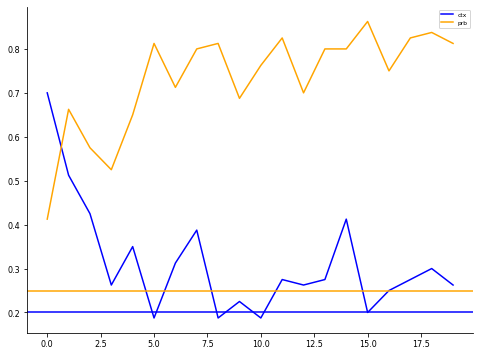

In [467]:
def plot_accuracies_old(ctx_accuracy,ctx_chance, prb_accuracy, prb_chance):
    # ctx_accuracy, ctx_chance = get_svm_accuracy(arr, lab['context'])
    # prb_accuracy, prb_chance = get_svm_accuracy(arr, lab['probe'])

    fig, ax = plt.subplots()
    _ = ax.plot(ctx_accuracy, color='blue', label='ctx')
    _ = ax.axhline(ctx_chance, color='blue')

    _ = ax.plot(prb_accuracy, color='orange', label='prb')
    _ = ax.axhline(prb_chance, color='orange')
    _ = ax.legend()

    return fig

def plot_accuracies(ctx_accuracy,ctx_chance, prb_accuracy, prb_chance):

    fig = go.Figure()
    t = np.linspace(0,1,len(ctx_accuracy), endpoint=False)

    # ctx line and chance
    _ = fig.add_trace(go.Scatter(x=t, y=ctx_accuracy, mode='lines',
                                 line_color='green', name='context'))
    _ = fig.add_hline(y=ctx_chance, opacity=1,
                       line=dict(color='green',
                                 dash='dot',
                                 width=1))

    # prb lline and chance
    _ = fig.add_trace(go.Scatter(x=t, y=prb_accuracy, mode='lines',
                                 line_color='black', name='probe'))

    _ = fig.add_hline(y=prb_chance, opacity=1,
                       line=dict(color='black',
                                 dash='dot',
                                 width=1))


    fig.update_layout(width=96*4, height=96*3,
                      margin={'l': 10, 'r': 10, 't': 10, 'b': 10, },
                      template='simple_white',
                      showlegend=True
                      )
    return fig


def decode_and_plot(arr):
    ufd, lbl = unfold_rep_ctx_prb(arr)
    fig = plot_accuracies_old(*get_svm_accuracy(ufd, lbl['context']), *get_svm_accuracy(ufd, lbl['probe']) )
    return fig, ufd, lbl

fig, _, _ = decode_and_plot(raster)
# img_bytes = fig.to_image(format="png", scale=1)
# Image(img_bytes)

# destroy context information
use my old tool to shuffle the 5 dimensional raster along the contex dimension (2)
but to do so independently for each trial dimension.
I believe this should be equivalent to concatenating the Trial and Context dimension
and shuffling them together.


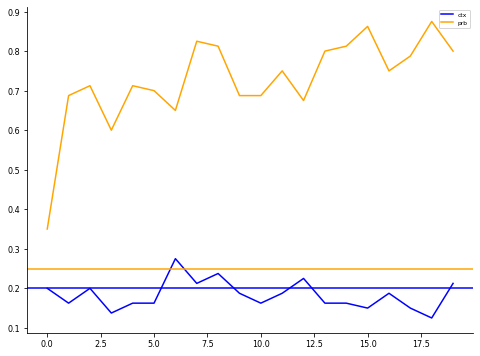

In [468]:
rand_raster = shuffle_along_axis(raster.copy(), shuffle_axis=2, indie_axis=0,
                                 rng=np.random.default_rng(42))


fig, _, _ = decode_and_plot(rand_raster)
# img_bytes = fig.to_image(format="png", scale=1)
# Image(img_bytes)

# Principal components
contain tangled information for both context and probe
As expected prediction accuracy increases with the number of components considered,
and it's higher for the Probe than the Context identity as expected,
furthermore, the starting accuracy is higher for probe than for context, which is expected.

using 1 PCs
using 2 PCs
using 3 PCs
using 4 PCs
using 5 PCs
using 6 PCs
using 7 PCs
using 8 PCs
using 9 PCs


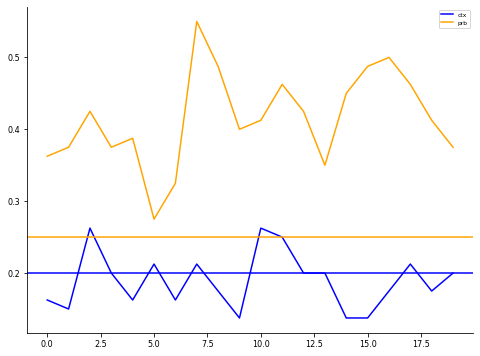

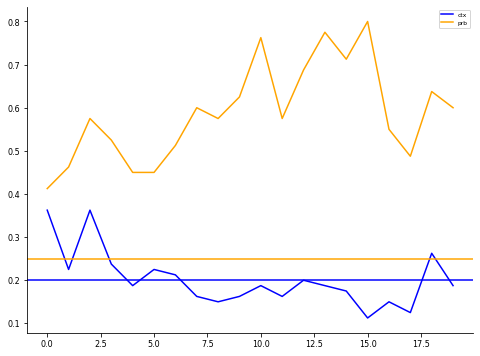

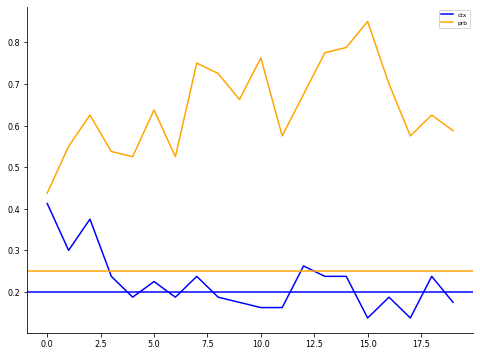

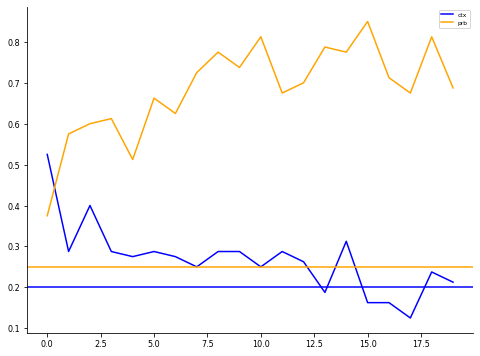

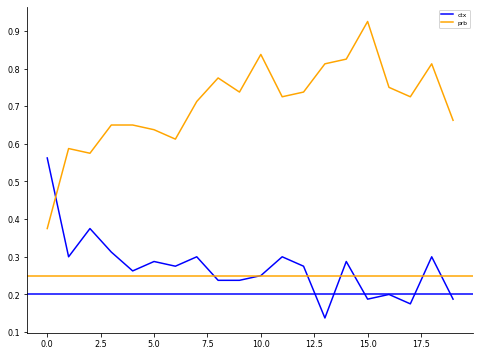

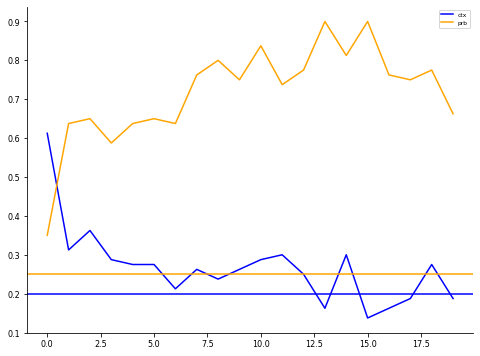

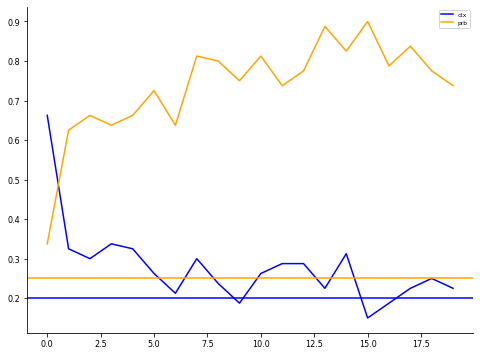

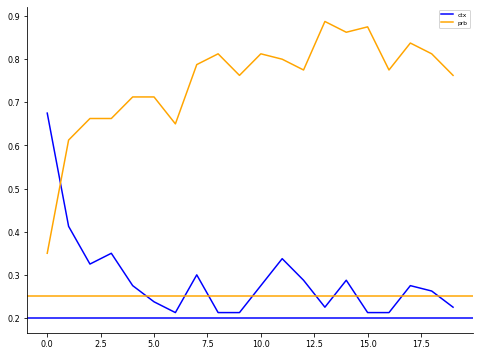

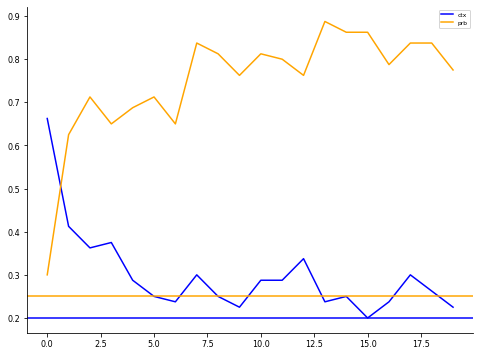

In [469]:
PC_raster = rasters['PCA'] # slice PC1, keeping dimension

n_pcs = PC_raster.shape[1]
for ii in range(1,10):
    # uses a slice of up to n components
    print(f'using {ii} PCs')
    fig, _, _ = decode_and_plot(PC_raster[:,np.arange(ii),...])
    # img_bytes = fig.to_image(format="png", scale=1)
    # Image(img_bytes)

# recover context

now that we know the probe information is there for PCs we can try to use it
to recover the information for the shuffled raster

using 28 PCs


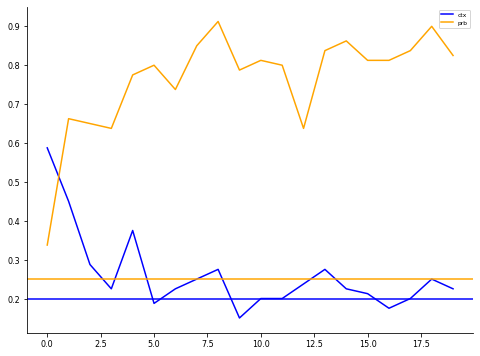

In [477]:

PC_raster = rasters['PCA'] # slice PC1, keeping dimension

n_pcs = PC_raster.shape[1]
# for ii in range(1,10):
for ii in [n_pcs]:
    print(f'using {ii} PCs')
    # quick and dirty: concatenate random and a slice of PC data
    merged = np.concatenate([rand_raster, PC_raster[:,np.arange(ii),...]], axis=1)
    fig, _, _ = decode_and_plot(merged)



using 28 PCs


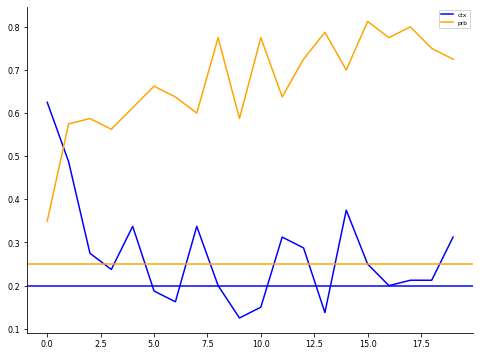

In [478]:
# randomize all
PC_raster = rasters['PCA'] # slice PC1, keeping dimension

rand_all_raster = shuffle_along_axis(raster.copy(), shuffle_axis=[2,3], indie_axis=0,
                                 rng=np.random.default_rng(42))

n_pcs = PC_raster.shape[1]
# for ii in range(1,10):
for ii in [n_pcs]:
    print(f'using {ii} PCs')
    # quick and dirty: concatenate random and a slice of PC data
    merged = np.concatenate([rand_all_raster, PC_raster[:,np.arange(ii),...]], axis=1)
    fig, _, _ = decode_and_plot(merged)


# better recovery

seems like adding the PCs as extra features does not yield Probe dictimination accuracy to the level of the PCs alone
A more clean alternative is to destroy context effects by averaging them out, and then recovering them by adding the
right marginal form the PCs.

Sounds convoluted because it is!

(16, 47, 1, 4, 20)
(16, 28, 5, 4, 20)


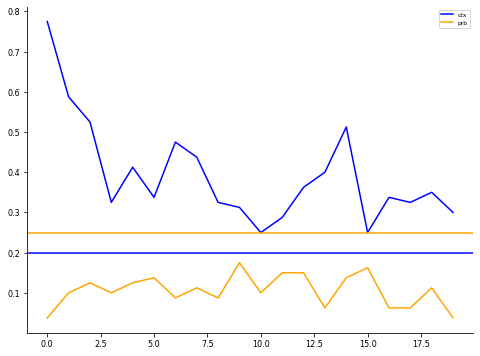

In [471]:
# destroy ctx info by average
avg_raster = np.mean(raster, axis=2, keepdims=True)
print(avg_raster.shape)



# remove average Probe response from PCs
PC_ctx = PC_raster - np.mean(PC_raster, axis=2, keepdims=True)
print(PC_ctx.shape)

fig, _, _ = decode_and_plot(PC_ctx)

# uf, lb = unfold_rep_ctx_prb(PC_ctx)
# _ = plot_accuracies(uf, lb)

In [476]:
print(avg_raster.shape, PC_ctx.shape)

(16, 47, 1, 4, 20) (16, 28, 5, 4, 20)


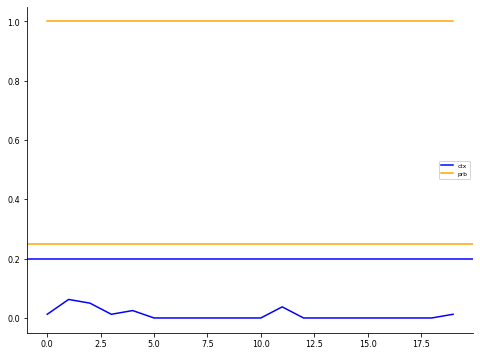

In [473]:
# for starters add just PC1 to all neurons
recoved = avg_raster + PC_ctx[:,[0],...]

fig, _, _ = decode_and_plot(recoved)

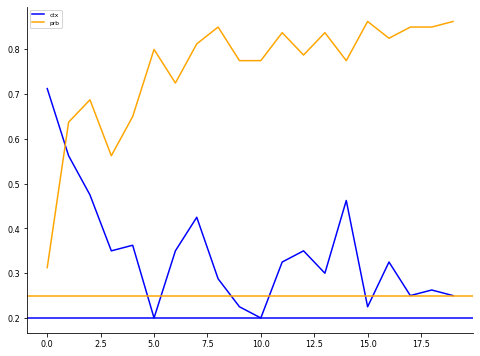

In [430]:
# PC_ctx = PC_raster - np.mean(PC_raster, axis=2, keepdims=True)
uf, lb = unfold_rep_ctx_prb(PC_raster)
_ = plot_accuracies(uf, lb)

# now try to get all sites

In [ ]:
# quick cache
acc_df_file = pl.Path(config['paths']['analysis_cache']) / f'221219_SC_decoder_accuracies'

recache_acc = False

if acc_df_file.exists():
    print('cache found, reloading')
    accuracy_df = jl.load(acc_df_file)

elif (not acc_df_file.exists()) or recache_acc:
    accuracy_df = list()
    for site in good_sites:

        fn = tensor_loaders['SC']
        if fn.check_call_in_cache(site, **raster_meta):
            print(f'cache found for {site}')
            raster, _ = fn(site, **raster_meta)
            print(f'####\n'
                  f'raster shape {raster.shape}'
                  )
        else:
            print(f"cant load {fn} with {raster_meta}.\n this should be cached, why is it failing? ")

        unfolded, labels = unfold_rep_ctx_prb(raster)

        for part in ['context', 'probe']:
            accuracy, chance = get_svm_accuracy(unfolded, labels[part])

            d = {'site': site,
                 'part': part,
                 'accuracy': accuracy,
                 'chance': chance}

            accuracy_df.append(d)

    accuracy_df = pd.DataFrame(accuracy_df)

    jl.dump(accuracy_df, acc_df_file)

In [252]:
accuracy_df.groupby('chance').agg('count')

,site,part,accuracy
chance,,,
0.100000,28,28,28
0.111111,1,1,1
0.250000,35,35,35


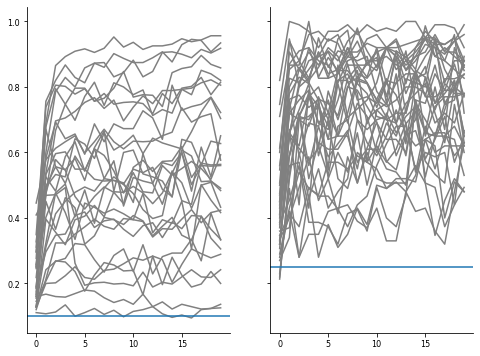

In [262]:
fig, axes = plt.subplots(1, 2, squeeze=True, sharey=True, sharex=True)

for cc, chance in enumerate([0.1, 0.25]):
    ax = axes[cc]
    arr = np.stack(accuracy_df.query(f"chance == {chance}").loc[:, 'accuracy'].values)
    _ = ax.plot(arr.T, color='gray')
    _ = ax.axhline(chance)